In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are avail|able in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/test.csv


In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [82]:
train = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/test.csv')

In [83]:
train.shape,test.shape

((10000, 9), (3320, 8))

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   area_type     10000 non-null  object 
 2   availability  10000 non-null  object 
 3   location      9999 non-null   object 
 4   size          9987 non-null   object 
 5   total_sqft    9967 non-null   float64
 6   bath          9936 non-null   float64
 7   balcony       9525 non-null   float64
 8   price         10000 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 703.3+ KB


In [85]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3320 non-null   int64  
 1   area_type     3320 non-null   object 
 2   availability  3320 non-null   object 
 3   location      3320 non-null   object 
 4   size          3317 non-null   object 
 5   total_sqft    3307 non-null   float64
 6   bath          3311 non-null   float64
 7   balcony       3186 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 207.6+ KB


In [86]:
train.isna().sum()

id                0
area_type         0
availability      0
location          1
size             13
total_sqft       33
bath             64
balcony         475
price             0
dtype: int64

In [87]:
train.duplicated().sum()

0

In [88]:
def clean_sqft_to_num(sqft):
    if isinstance(sqft,str):
        sqft =sqft.replace(',','')
        tokens = sqft.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(tokens[0])
        try:
            return float(sqft)
        except:
            return None
    return sqft

def clean_bhk_to_num(size):
    if isinstance(size,str):
        try:
            return int(size.split(' ')[0].replace('BHK','').replace('Bedroom','').strip())
        except:
            return None
    return size

In [89]:
def create_preprocessor(X):
    num_features = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = X.select_dtypes(include=[object]).columns.tolist()

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
    ], remainder='passthrough', verbose_feature_names_out=False)
    return preprocessor


In [90]:
def get_all_models():
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(random_state=42),
        "Lasso": Lasso(random_state=42),
        "ElasticNet": ElasticNet(random_state=42),
        "SGDRegressor": SGDRegressor(random_state=42, max_iter=1000, tol=1e-3),
        "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, n_jobs=1),
        "GradientBoosting": GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=3),
        "XGB": xgb.XGBRegressor(random_state=42, n_estimators=200, max_depth=6, n_jobs=1, verbosity=0),
        "LGBM": lgb.LGBMRegressor(random_state=42, n_estimators=500, num_leaves=31, n_jobs=1, verbose=-1)
        # "CatBoost": CatBoostRegressor(random_state=42, iterations=500, learning_rate=0.05, depth=6, verbose=0)
    }
    return models

In [91]:
def evaluate_models(X, y, preprocessor, cv=3):
    models = get_all_models()
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

    results = []
    for name, model in models.items():
        pipe = Pipeline([('pre', preprocessor), ('model', model)])
        try:
            scores = cross_val_score(pipe, X, y, cv=kfold, scoring='r2', n_jobs=-1)
            results.append({"Model": name, "R2_mean": scores.mean(), "R2_std": scores.std()})
        except Exception as e:
            print(f"Skipping {name} due to error: {e}")

    results_df = pd.DataFrame(results).sort_values("R2_mean", ascending=False)
    return results_df

In [92]:
def tune_top_models(X, y, preprocessor, top_models):
    models = get_all_models()

    tune_spaces = {
        'Ridge': {'model__alpha': [0.1,1,10,50]},
        'GradientBoosting': {'model__n_estimators':[50,100,200],
                             'model__max_depth':[2,3,5],
                             'model__learning_rate':[0.03,0.05,0.1]},  
        'ElasticNet': {'model__alpha':[0.1,0.5,1,5],'model__l1_ratio':[0.1,0.5,0.9]},
        'SGDRegressor': {'model__alpha':[0.0001,0.001,0.01],'model__penalty':['l2','elasticnet']},
        'SVR': {'model__C':[0.5,1,2],'model__epsilon':[0.05,0.1,0.2]},
        'XGB': {'model__n_estimators':[200,400],'model__max_depth':[5,7,9],'model__learning_rate':[0.03,0.05,0.1],'model__subsample':[0.7,0.9]}

    }

    tuned_results = []
    for name in top_models:
        if name not in tune_spaces:
            continue
        pipe = Pipeline([('pre', preprocessor), ('model', models[name])])
        rs = RandomizedSearchCV(pipe, tune_spaces[name], n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)
        rs.fit(X, y)
        tuned_results.append({
            "Model": name + " (Tuned)",
            "R2_mean": rs.best_score_,
            "Best_params": rs.best_params_
        })

    tuned_df = pd.DataFrame(tuned_results).sort_values("R2_mean", ascending=False)
    return tuned_df


In [93]:
def train_final_model(X, y, preprocessor, tuned_df):
    best_model_name = tuned_df.iloc[0]['Model'].replace(' (Tuned)','')
    best_params = tuned_df.iloc[0]['Best_params']
    models = get_all_models()

    final_model = models[best_model_name]
    for k,v in best_params.items():
        if hasattr(final_model, k.replace('model__','')):
            setattr(final_model, k.replace('model__',''), v)

    final_pipe = Pipeline([('pre', preprocessor), ('model', final_model)])
    final_pipe.fit(X, y)
    return final_pipe, best_model_name

In [94]:
for df in [train, test]:
    df['total_sqft'] = df['total_sqft'].apply(clean_sqft_to_num)
    df['Bedrooms'] = df['size'].apply(clean_bhk_to_num)
    df['Bath_per_bhk'] = df['bath'] / (df['Bedrooms'].fillna(1)+1e-6)
    df.drop('size', axis=1, inplace=True)

train['price_per_sqft'] = (train['price'] * 100000) / train['total_sqft']
train = train[(train['price_per_sqft'].between(train['price_per_sqft'].quantile(0.005),
                                               train['price_per_sqft'].quantile(0.995)))]
train.drop('price_per_sqft', axis=1, inplace=True)

X = train.drop(columns=['price','id'])
y = train['price']
test_X = test.drop(columns=['id'])

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fit the preprocessor (only to get imputed numeric features)
preprocessor = create_preprocessor(X)
preprocessor.fit(X)

# Extract numeric features after imputation
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
num_pipe = preprocessor.named_transformers_['num']
X_num_imputed = pd.DataFrame(
    num_pipe.named_steps['imputer'].transform(X[num_features]), 
    columns=num_features
)

# Check multicollinearity
def check_multicollinearity(df, threshold=5.0):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif_data['high_multicollinearity'] = vif_data['VIF'] > threshold
    return vif_data

vif_result = check_multicollinearity(X_num_imputed)
print(vif_result)


        feature        VIF  high_multicollinearity
0    total_sqft   5.083061                    True
1          bath  32.145712                    True
2       balcony   5.300239                    True
3      Bedrooms  26.921307                    True
4  Bath_per_bhk   8.771946                    True


/tmp/ipykernel_37/3930998562.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['price'], bins=50, kde=True)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


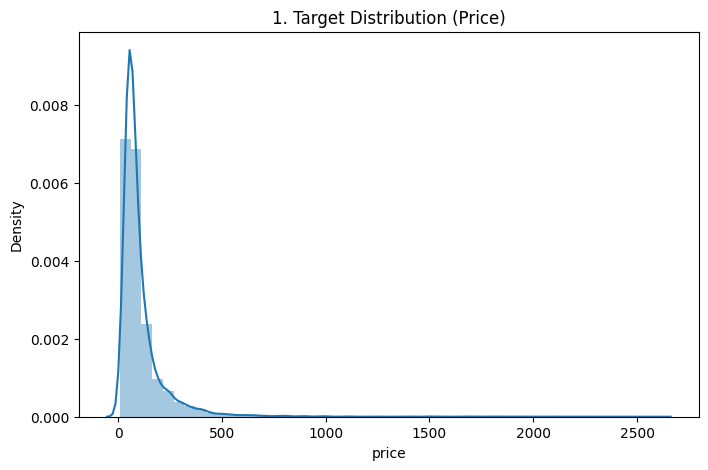

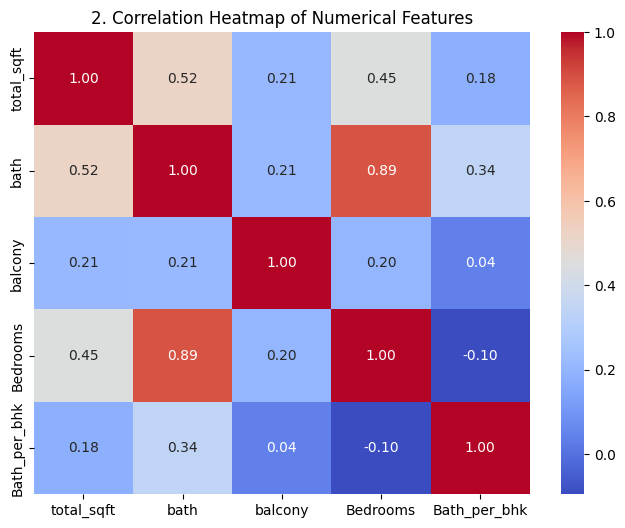

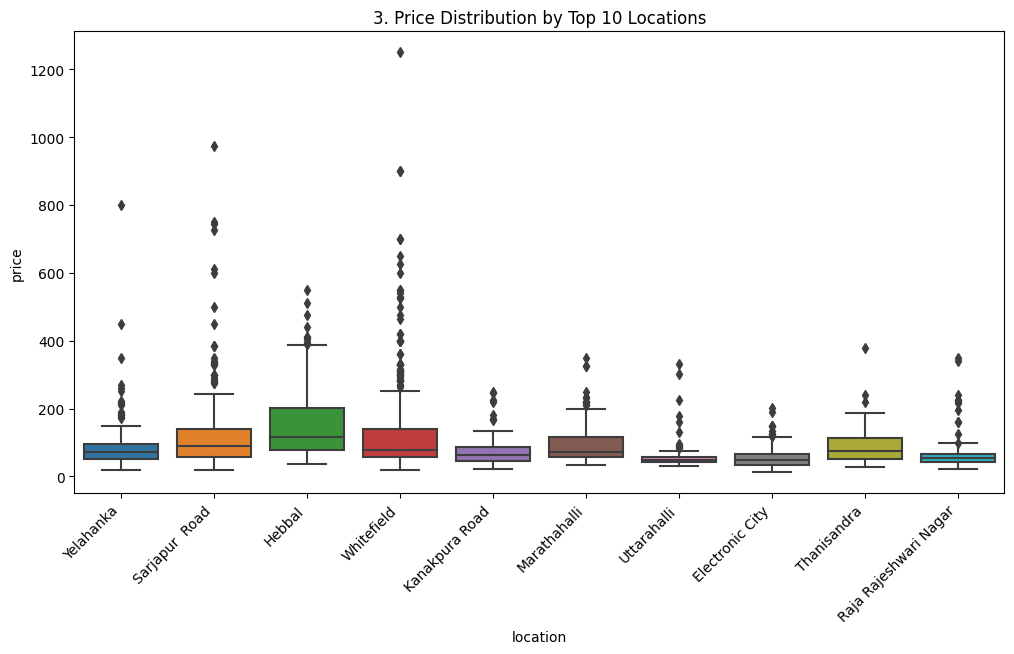

In [96]:
# 1. Target Distribution
plt.figure(figsize=(8, 5))
sns.distplot(train['price'], bins=50, kde=True)
plt.title('1. Target Distribution (Price)')
plt.show()

# 2. Numerical Feature Correlation Heatmap
num_cols = X.select_dtypes(include=np.number).columns.tolist()
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('2. Correlation Heatmap of Numerical Features')
plt.show()

# 3. Price vs. Location (Top 10 Locations)
top_locations = X['location'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y=y, data=train[train['location'].isin(top_locations)])
plt.xticks(rotation=45, ha='right')
plt.title('3. Price Distribution by Top 10 Locations')
plt.show()

In [97]:
preprocessor = create_preprocessor(X)
baseline_results = evaluate_models(X, y, preprocessor)
display(baseline_results)

# 🔍 Tune Top 3 Models
top_models = baseline_results['Model'].head(3).tolist()
tuned_df = tune_top_models(X, y, preprocessor, top_models)
display(tuned_df)

# 🏁 Train Final Model
final_pipe, best_model_name = train_final_model(X, y, preprocessor, tuned_df)
print(f"✅ Final chosen model: {best_model_name}")

# 🧾 Predict on unseen data
final_preds = final_pipe.predict(test)

,Model,R2_mean,R2_std
8,XGB,7.298244e-01,9.464657e-03
7,GradientBoosting,7.258358e-01,5.059164e-03
6,RandomForest,7.144806e-01,5.324740e-03
1,Ridge,7.106187e-01,1.258591e-02
4,SGDRegressor,6.730371e-01,8.211244e-03
9,LGBM,6.592642e-01,2.466066e-02
2,Lasso,6.346327e-01,9.964461e-03
3,ElasticNet,5.689024e-01,4.116348e-02
5,SVR,3.010432e-01,4.195801e-02
0,LinearRegression,-2.218714e+18,2.407385e+18


,Model,R2_mean,Best_params
0,XGB (Tuned),0.734610,"{'model__subsample': 0.7, 'model__n_estimators..."
1,GradientBoosting (Tuned),0.720008,"{'model__n_estimators': 200, 'model__max_depth..."


✅ Final chosen model: XGB


In [98]:
submission = pd.DataFrame({
    "id": test['id'],
    "price": final_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission saved as 'submission.csv'")

✅ Submission saved as 'submission.csv'


In [99]:
# submission = pd.DataFrame({'id': test['id'], 'price': final_preds})
# submission['price'] = submission['price'].clip(lower = 0)
# submission.to_csv("/kaggle/working/submission.csv", index=False)

In [100]:
submission.head()

,id,price
0,0,30.648968
1,1,100.668083
2,2,56.595528
3,3,163.879791
4,4,174.129898
